In [7]:
import numpy as np
from pathlib import Path
import pandas as pd
from libsvm.svmutil import *
import matplotlib.pyplot as plt

In [8]:
import numpy as np

class CARTRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _calculate_squared_error(self, y):
        return np.sum((y - np.mean(y)) ** 2)

    def _find_best_split(self, X, y):
        m, n_features = X.shape
        min_error = float('inf')
        best_feature = None
        best_threshold = None

        for feature_index in range(n_features):
            feature_values = np.unique(X[:, feature_index])
            # Decide threshold
            thresholds = 0.5 * (feature_values[:-1] + feature_values[1:])
            #threshold = np.median(feature_values)
            
            # Split two parts
            for threshold in thresholds:
                left_indices = X[:, feature_index] <= threshold
                right_indices = ~left_indices

                left_error = self._calculate_squared_error(y[left_indices])
                right_error = self._calculate_squared_error(y[right_indices])

                total_error = left_error + right_error

                if total_error < min_error:
                    min_error = total_error
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        unique_labels = np.unique(y)

        # If only one class in the node or max depth reached, create a leaf node
        if len(unique_labels) == 1 or (self.max_depth is not None and depth == self.max_depth):
            return {'class': unique_labels[0], 'leaf': True}

        # Find the best split
        best_feature, best_threshold = self._find_best_split(X, y)

        # If no good split is found, create a leaf node
        if best_feature is None:
            return {'class': np.random.choice(unique_labels), 'leaf': True}

        # Split the data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices

        # Recursively build left and right subtrees
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        # Return the decision node
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree,
            'leaf': False
        }

    def predict_one(self, node, x):
        if node['leaf']:
            return node['class']
        else:
            if x[node['feature']] <= node['threshold']:
                return self.predict_one(node['left'], x)
            else:
                return self.predict_one(node['right'], x)

    def predict(self, X):
        return [self.predict_one(self.tree, x) for x in X]
    

def calculate_squared_error(labels, preds):
    mean = np.mean(preds)
    return np.var(preds - labels)

In [9]:
# Sample usage
def test():
    # Assume you have a dataset represented by X and y
    X = np.array([[2.0, 3.0], [1.0, 2.0], [4.0, 5.0], [3.0, 4.0]])
    y = np.array([1.0, 0.0, 1.0, 0.0])

    # Create and fit the decision tree
    tree = CARTRegressor(max_depth=3)
    tree.fit(X, y)

    # Make predictions
    predictions = tree.predict(X)
    print("Predictions:", predictions)

## Data Preprocess

In [10]:
data_dir = Path("data")
# dat -> array of list
y_train, x_train = svm_read_problem(data_dir / "hw6_train.dat")
y_test,  x_test  = svm_read_problem(data_dir / "hw6_test.dat")
x_train = pd.DataFrame(x_train).to_numpy()
x_test = pd.DataFrame(x_test).to_numpy()
y_train = pd.DataFrame(y_train).to_numpy().flatten()
y_test = pd.DataFrame(y_test).to_numpy().flatten()
print(f"Numbers of train data {len(x_train)}")
print(f"Numbers of test data {len(x_test)}")

Numbers of train data 3200
Numbers of test data 977


## Modeling

### Decision Tree

In [11]:
# Create and fit the decision tree
tree = CARTRegressor()
tree.fit(x_train, y_train)

# Make predictions
preds = tree.predict(x_train)
print("Ein:", calculate_squared_error(y_train, preds))

# Make predictions
preds = tree.predict(x_test)
print("Eout:", calculate_squared_error(y_test, preds))

Ein: 0.0
Eout: 8.79181041120804


### Random Forest

In [17]:
class RandomForestRegressor:
    def __init__(self, num_trees=2000, bagging_fraction=0.5):
        self.num_trees = num_trees
        self.bagging_fraction = bagging_fraction
        self.trees = []

    def fit(self, x_train, y_train):
        # Number of examples
        N = x_train.shape[0]

        # Build T trees
        for t in tqdm(range(self.num_trees), desc="Processing Trees", unit="tree"):
            # Bagging by sampling with replacement
            indices = np.random.choice(N, size=int(self.bagging_fraction * N), replace=True)
            X_bagged = x_train[indices]
            y_bagged = y_train[indices]

            # Create and train the decision tree
            tree = CARTRegressor()
            tree.fit(X_bagged, y_bagged)

            self.trees.append(tree)

    def predict(self, x_test):
        # Make predictions on the test set using all trees
        preds = np.array([tree.predict(x_test) for tree in rf_regressor.trees])
        return np.mean(preds, axis=0)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

rf_regressor = RandomForestRegressor(num_trees=2000, bagging_fraction=0.5)

# Fit the model
rf_regressor.fit(x_train, y_train)

Processing Trees: 100%|███████████████████████████████████████████████████████████| 2000/2000 [19:30<00:00,  1.71tree/s]


In [20]:
# Total Ein and Eout
tree_predictions = rf_regressor.predict(x_train)
model_ein = np.mean((tree_predictions - y_train)**2, axis=0)

tree_predictions = rf_regressor.predict(x_test)
model_eout = np.mean((tree_predictions - y_test)**2, axis=0)
print("Ein : {}".format(model_ein))
print("Eout : {}".format(model_eout))

Ein : 1.66845507859375
Eout : 4.704350319089048


In [21]:
tree_predictions = rf_regressor.trees

tree_preds = np.array([tree.predict(x_train) for tree in tree_predictions])
tree_eins = np.array([np.mean((y_train - pred)**2) for pred in tree_preds])

tree_preds = np.array([tree.predict(x_test) for tree in tree_predictions])
tree_eouts = np.array([np.mean((y_test - pred)**2) for pred in tree_preds])

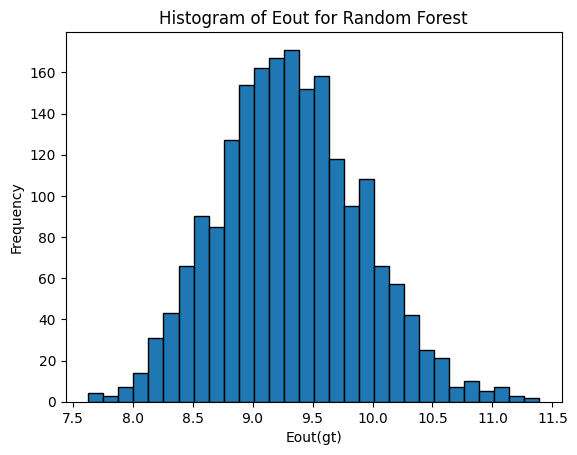

In [22]:
import seaborn as sns
# Plot histogram of Eout
plt.hist(tree_eouts, bins=30, edgecolor='black')
plt.xlabel('Eout(gt)')
plt.ylabel('Frequency')
plt.title('Histogram of Eout for Random Forest')
plt.show()

Text(0, 0.5, 'eout')

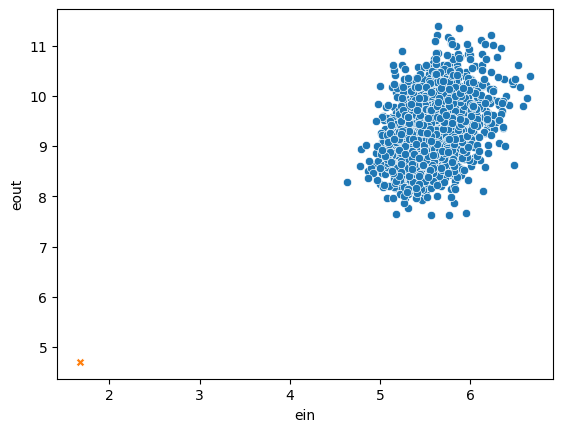

In [24]:
sns.scatterplot(x=tree_eins, y=tree_eouts)
sns.scatterplot(x=[model_ein], y=[model_eout], marker='X')
plt.xlabel("ein")
plt.ylabel("eout")

In [63]:
tree_predictions = rf_regressor.trees
tree_preds = np.array([tree.predict(x_test) for tree in tree_predictions])

In [77]:
# model
num_trees = 2000
model_eout_various_depth = []
for t in range(num_trees):
    model_preds = np.mean(tree_preds[:t], axis=0)
    model_eout = np.mean((model_preds - y_test)**2)
    model_eout_various_depth.append(model_eout)

/usr/local/anaconda3/envs/ml_hw6/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/ml_hw6/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/usr/local/anaconda3/envs/ml_hw6/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [78]:
# tree
n_trees = 2000
eouts_all, x_all = [], []
for i in range(n_trees):
    eouts = tree_eouts[:i]
    for eout in eouts:
        eouts_all.append(eout)
    for j in range(i):
        x_all.append(i)

In [85]:
(np.array(model_eout_various_depth) > 5).sum()

17

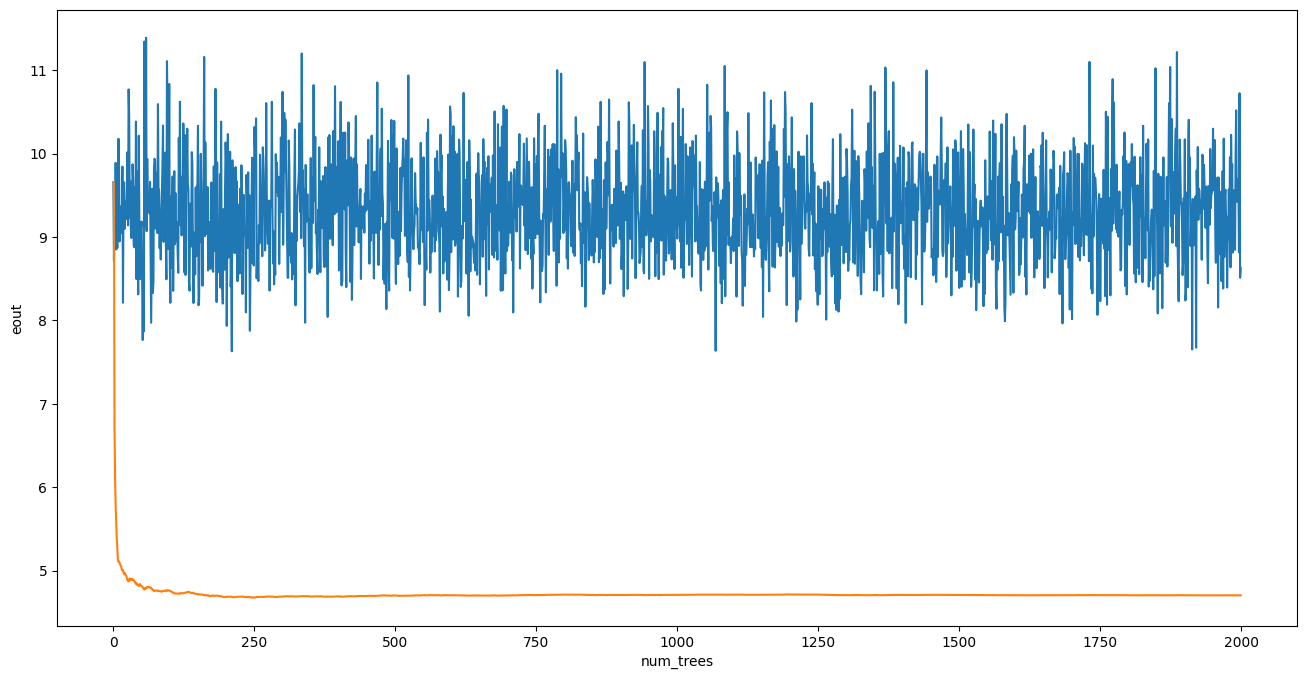

In [95]:
plt.figure(figsize=(16,8))
sns.lineplot(x=list(range(2000)), y=tree_eouts)
sns.lineplot(x=list(range(2000)), y=model_eout_various_depth)
plt.xlabel("num_trees")
plt.ylabel("eout")
plt.show()

## Visualization

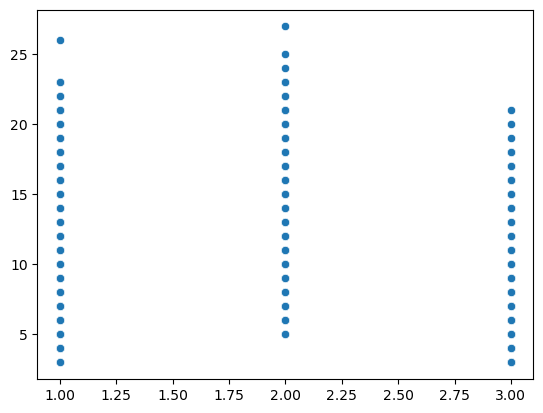

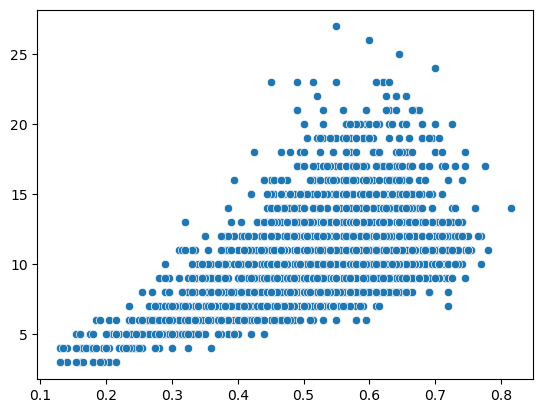

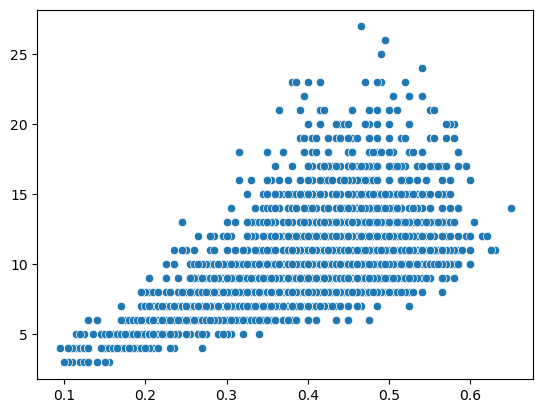

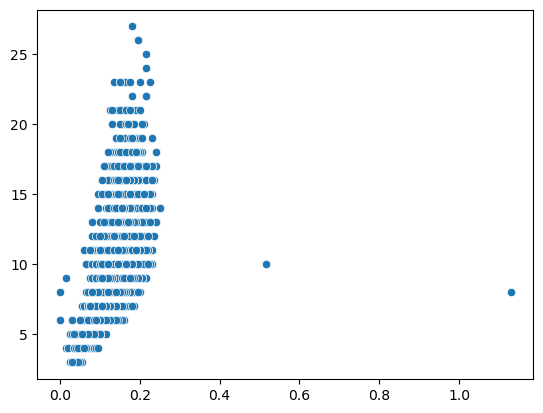

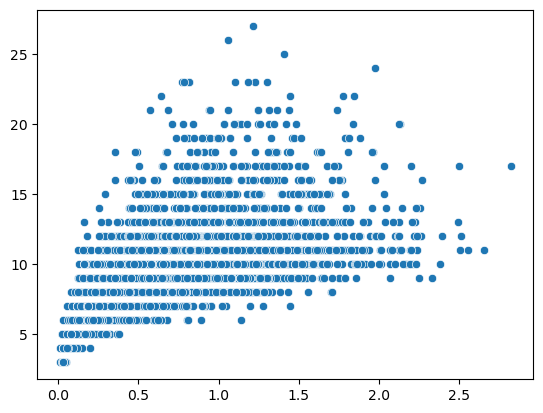

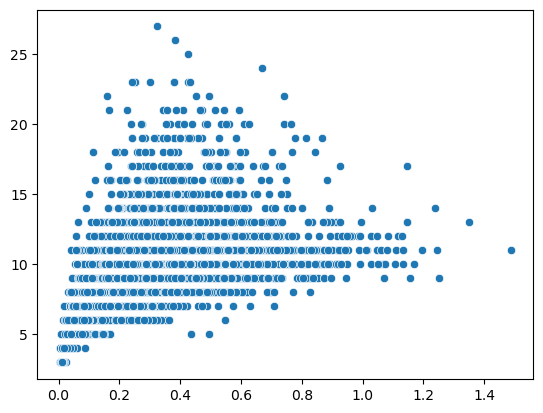

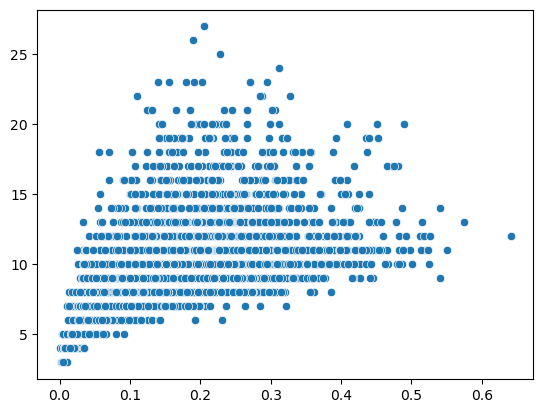

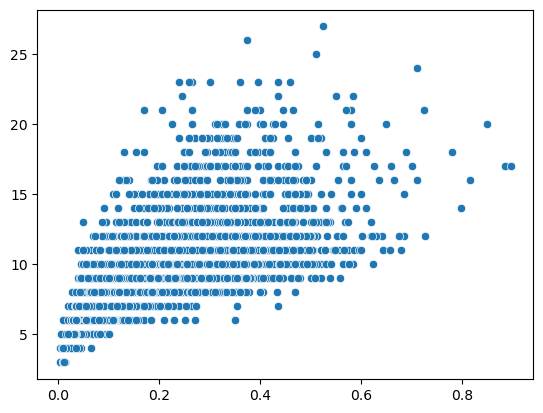

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_ids = list(range(8))
for feature_id in feature_ids:
    sns.scatterplot(x=x_train[:,feature_id], y=y_train)
    plt.show()

array([2., 1., 4., 3.])